In [1]:
import cv2
import shutil
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
POS_PATH = os.path.join('Data', 'positive')
NEG_PATH = os.path.join('Data', 'negative')
ANC_PATH = os.path.join('Data', 'anchor')

In [5]:
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [6]:
for directory in os.listdir('DATASET'):
    for file in os.listdir(os.path.join('DATASET', directory)):
        EX_PATH = os.path.join('DATASET', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [7]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'Data\\anchor\\0e2a5c75-152b-11ef-8f6a-581cf842fc9c.jpg'

In [8]:
camera= cv2.VideoCapture(0)
while camera.isOpened(): 
    ret, frame = camera.read()
    frame = frame[120:120+250,200:200+250, :]
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, f"{uuid.uuid1()}.jpg")
        cv2.imwrite(imgname, frame)
    
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, f"{uuid.uuid1()}.jpg")
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
camera.release()
cv2.destroyAllWindows()

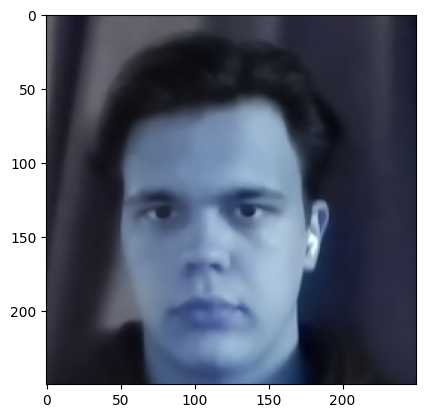

In [9]:
# Получаем размеры исходного изображения
height, width, _ = frame.shape

# Вычисляем координаты центра изображения
center_y = height // 2
center_x = width // 2

# Вычисляем координаты верхнего левого угла выводимого изображения
top_y = center_y - 125
left_x = center_x - 125

# Выводим изображение размером 250x250 пикселей
plt.imshow(frame[top_y:top_y+250, left_x:left_x+250, :])
plt.show()

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\\*.jpg').take(3000)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
print(dir_test.next())

b'Data\\anchor\\a7b99895-0c8c-11ef-aeb0-581cf842fc9c.jpg'


In [13]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = tf.math.divide(img, 255.0)
    return img

In [14]:
img = preprocess('Data\\anchor\\4a6ab3b0-0c8e-11ef-bc82-581cf842fc9c.jpg')

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [16]:
samples = data.as_numpy_iterator()

In [17]:
exampple = samples.next()

In [18]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [19]:
res = preprocess_twin(*exampple)

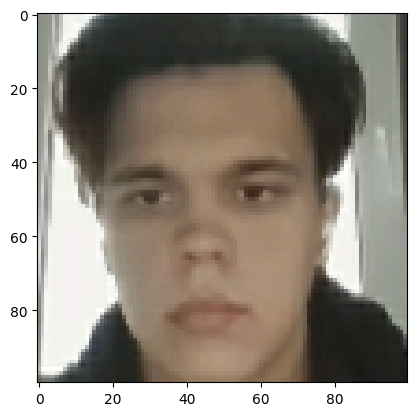

In [20]:
plt.imshow(res[1])

In [21]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [22]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [24]:
inp = Input(shape=(100,100,3), name='input_image')

In [25]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [26]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [27]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [28]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [29]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [30]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')



In [31]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [32]:
embedding = make_embedding()

In [33]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
      # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding[0] - validation_embedding[0])

In [34]:
l1 = L1Dist()

In [35]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [36]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [37]:
siamese_layer = L1Dist()

In [38]:
distances = siamese_layer(inp_embedding, val_embedding)


In [39]:
classifier = Dense(1, activation='sigmoid')(distances)

In [40]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [41]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [42]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [43]:
siamese_model = make_siamese_model()

In [44]:
    binary_cross_loss = tf.losses.BinaryCrossentropy()

In [45]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [46]:
checkpoint_dir = r"C:\Users\karpo\OneDrive\Desktop\Проект НС\checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [47]:
test_batch = train_data.as_numpy_iterator()

In [48]:
batch_1 = test_batch.next()

In [49]:
X = batch_1[:2]

In [50]:
y = batch_1[2]

In [51]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [52]:
from tensorflow.keras.metrics import Precision, Recall

In [53]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [56]:
EPOCHS = 50

In [65]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
10/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
0.12210038 0.8101266 0.9846154

 Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━

KeyboardInterrupt: 

In [54]:
from tensorflow.keras.metrics import Precision, Recall

In [55]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [56]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


In [57]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [58]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [59]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

0.75

In [60]:
r = Recall()
p = Precision()
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
0.8378378 0.5344828


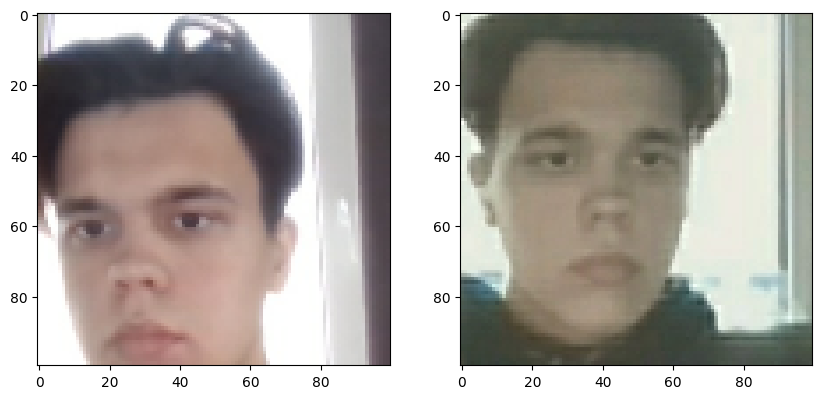

In [61]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [62]:
siamese_model.save('siamesemodelv2.h5')

ValueError: Unable to synchronously create dataset (name already exists)

In [ ]:
L1Dist

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

In [ ]:

# Путь к папке с изображениями
source_folder = r"C:\Users\karpo\OneDrive\Desktop\Проект НС\Data\positive"

# Путь к папке, куда нужно скопировать изображения
target_folder = r"C:\Users\karpo\OneDrive\Desktop\Проект НС\aplication_data\verification_data"

# Проверяем, что папки существуют
if not os.path.exists(source_folder):
    print(f"Папка '{source_folder}' не существует")
    exit()

if not os.path.exists(target_folder):
    print(f"Папка '{target_folder}' не существует")
    exit()

# Получаем список всех файлов в папке с изображениями
files = os.listdir(source_folder)

# Выбираем 50 случайных файлов
selected_files = random.sample(files, 50)

# Копируем выбранные файлы в папку назначения
for file in selected_files:
    source_path = os.path.join(source_folder, file)
    target_path = os.path.join(target_folder, file)
    shutil.copyfile(source_path, target_path)

print(f"Выбрано и скопировано 50 файлов из '{source_folder}' в '{target_folder}'")


In [ ]:
application_data\verification_images

In [ ]:
os.listdir(os.path.join('application_data', 'verification_img'))

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_img')):
    validation_img = os.path.join('application_data', 'verification_img', image)
    print(validation_img)

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [63]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite("C:/Users/karpo/OneDrive/Desktop/Проект НС/application_data/input_img/input_image.jpg", frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


In [ ]:
results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)

In [67]:
np.sum(np.squeeze(results) > 0.9)

NameError: name 'results' is not defined

In [66]:
results

NameError: name 'results' is not defined